In [1]:
# Input info
# se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
# barcodes_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/clonal_shifts/mincl.10_bothConds.False_p0.1/clones.dendro_dt_0.6__nuc.clust/"
clone_col = "den_clust"
atac_col = "cluster_labels"

# config
input_cond = "Input"

# params
min_clone_size = 2
p_thresh = 0.1 
n_shuffle=1000
n_cpus = 8


se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_prefilterMerge_impute/dendro_bc/results/noInput/knn/kparam_30"
barcodes_dir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
N_DONORS = 2
condition = "noInput" #"inputOnly" # noInput





In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 
import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
all_dir = join(outdir,"combDonors")
sep_dir = join(outdir,"sepDonors")


if not exists(all_dir):
    os.mkdir(all_dir)
    
if not exists(sep_dir):
    os.mkdir(sep_dir)

donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
        
    
# sim_all_dir = join(all_dir, "shuffle")
# sim_sep_dir = join(sep_dir, "shuffle")
# if not exists(sep_dir):
#     os.mkdir(sep_dir)
# if not exists(sim_all_dir):
#     os.mkdir(sim_all_dir)


In [4]:
%load_ext autoreload
%autoreload 2

## Load barcodes, and add donor id for the labels

In [5]:
barcodes_in = {}
for d in np.arange(N_DONORS):
    barcodes_in[d] = pd.read_csv(join(barcodes_dir,f"donor{d}.clones_dendro.csv"), index_col=0)

    barcodes_in[d][clone_col] = str(d) + "_" + barcodes_in[d][clone_col]
    
barcodes_in[d].head()

,size,donor,den_clust
lineage,,,
1_3,170,1,1_C0
1_19,41,1,1_C1
1_6,159,1,1_C1
1_17,54,1,1_C1
1_7,142,1,1_C1


## Load cells_meta

In [6]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t")
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]


## Map the new group to cells_meta

In [7]:
cells_meta[clone_col] = cells_meta.apply(lambda x: barcodes_in[int(x["donor"])].loc[x["name"], clone_col] , axis=1)

# Filter based on condition

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels,den_clust
Flt3l_AAACGAAGTCTGATTG-1,Flt3l,4239,4239,15047,1940,50,52,636,4173,8196,...,5280,4119,AAACGAAGTCTGATTG-1_Flt3l,Flt3l_AAACGAAGTCTGATTG-1,2,0,Flt3l,0_2,6,0_C1
Flt3l_AAACTCGGTAGGTCTT-1,Flt3l,2925,2925,13052,1674,43,26,526,4014,6769,...,4538,3532,AAACTCGGTAGGTCTT-1_Flt3l,Flt3l_AAACTCGGTAGGTCTT-1,16,1,Flt3l,1_16,3,1_C2
Flt3l_AAAGGGCAGACTTCCA-1,Flt3l,3562,3562,14297,2199,46,34,695,3497,7826,...,4653,3642,AAAGGGCAGACTTCCA-1_Flt3l,Flt3l_AAAGGGCAGACTTCCA-1,13,0,Flt3l,0_13,4,0_C2
Flt3l_AAATGAGGTATCCTTT-1,Flt3l,4915,4915,16671,2497,75,62,760,2906,10371,...,6459,4673,AAATGAGGTATCCTTT-1_Flt3l,Flt3l_AAATGAGGTATCCTTT-1,18,0,Flt3l,0_18,9,0_C2
Flt3l_AAATGCCGTGATAAGT-1,Flt3l,3886,3886,15323,2276,44,49,723,3740,8491,...,5109,3980,AAATGCCGTGATAAGT-1_Flt3l,Flt3l_AAATGCCGTGATAAGT-1,6,0,Flt3l,0_6,4,0_C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flt3l_TTGTCTACACGCGCAT-1,Flt3l,3451,3451,15235,1802,67,47,906,4440,7973,...,4570,3602,TTGTCTACACGCGCAT-1_Flt3l,Flt3l_TTGTCTACACGCGCAT-1,22,1,Flt3l,1_22,1,1_C0
Flt3l_TTGTTGTTCCCGTAGG-1,Flt3l,1932,1932,9459,1088,30,36,445,3480,4380,...,2723,2330,TTGTTGTTCCCGTAGG-1_Flt3l,Flt3l_TTGTTGTTCCCGTAGG-1,13,0,Flt3l,0_13,3,0_C2
Flt3l_TTTGAGGTCCCAGTAA-1,Flt3l,4268,4268,18292,2843,49,63,722,3209,11406,...,7211,4994,TTTGAGGTCCCAGTAA-1_Flt3l,Flt3l_TTTGAGGTCCCAGTAA-1,3,0,Flt3l,0_3,1,0_C1
Flt3l_TTTGGTTCAGGTGGTA-1,Flt3l,3156,3156,14050,1969,41,63,670,3384,7923,...,5026,3800,TTTGGTTCAGGTGGTA-1_Flt3l,Flt3l_TTTGGTTCAGGTGGTA-1,11,0,Flt3l,0_11,5,0_C2


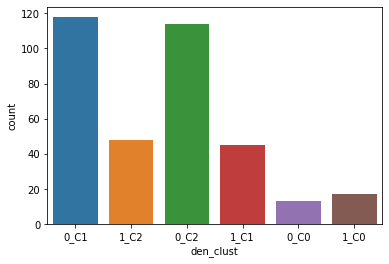

In [8]:
if condition == "inputOnly":
    cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
else:
    cells_meta = cells_meta.loc[cells_meta["condition"]!=input_cond]
sns.countplot(data=cells_meta,x=clone_col)
cells_meta

## construct the clone_groups and atac_cl_groups

## A) Loop through donor and run 

donor 0
['0_C0' '0_C1' '0_C2']
[1 3 4 5 6 9]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 1
bh shape (3, 6)


ic| 'clone min'


out_df Empty DataFrame
Columns: [index, variable, value, method]
Index: []
donor 1
['1_C0' '1_C1' '1_C2']
[1 2 3 4 5 6 9]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'
ic| 

Number of groups below p-val significance: 0


'clone all'


axs 1
bh shape (3, 7)


ic| 'clone min'


out_df    index variable  value      method
3   1_C0        2    0.0  global_all
20  1_C2        9    0.0  global_all
3   1_C0        2    0.0  global_min
20  1_C2        9    0.0  global_min
3   1_C0        2    0.0   clone_all
20  1_C2        9    0.0   clone_all
3   1_C0        2    0.0   clone_min
20  1_C2        9    0.0   clone_min


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


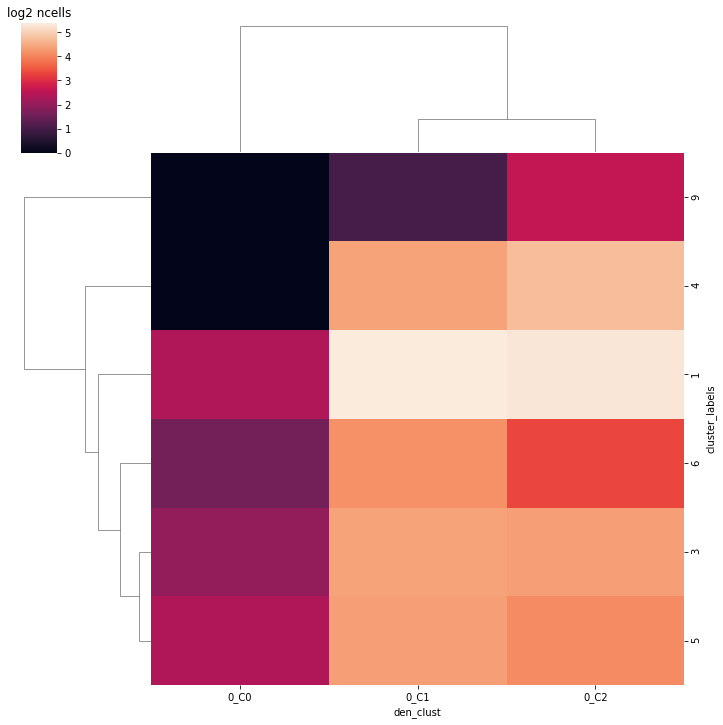

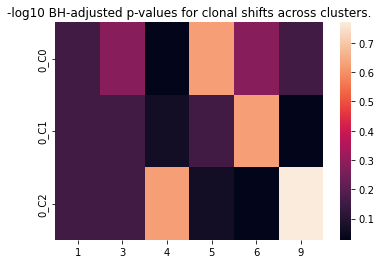

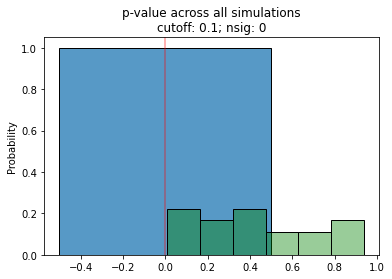

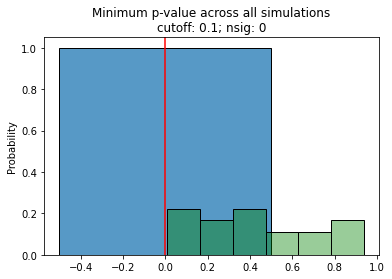

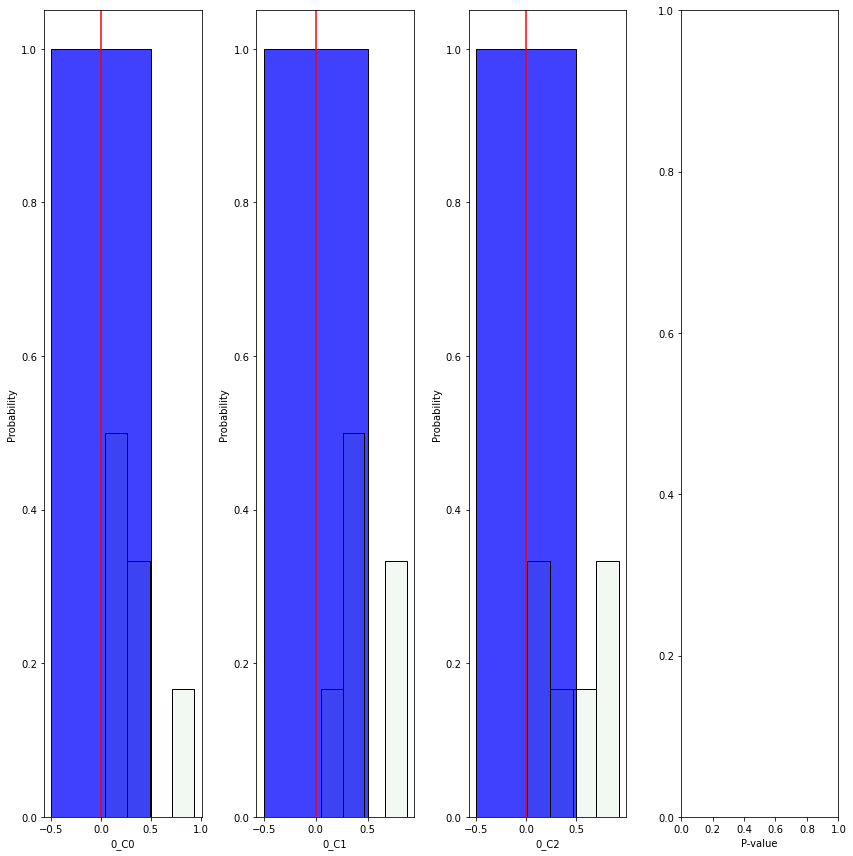

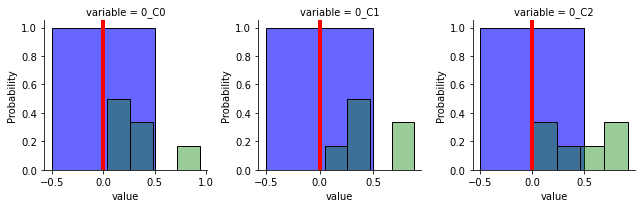

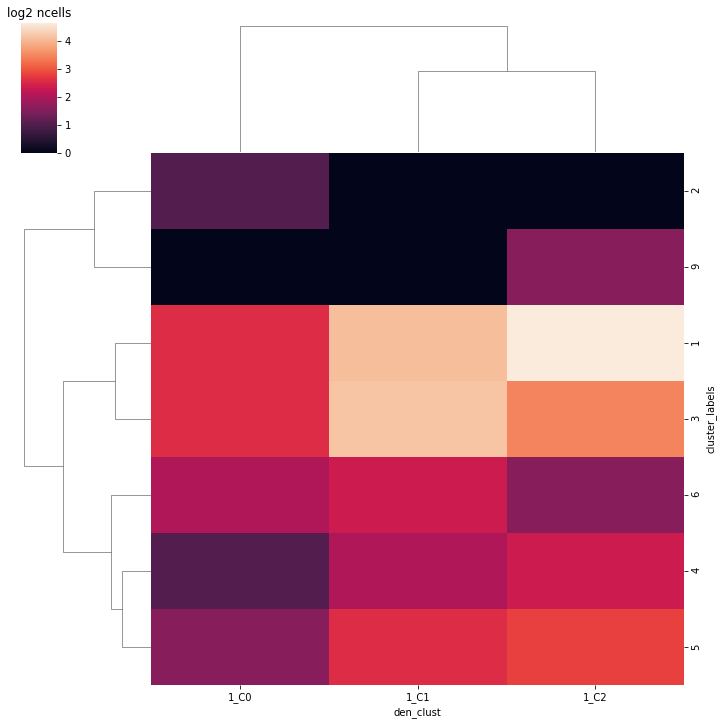

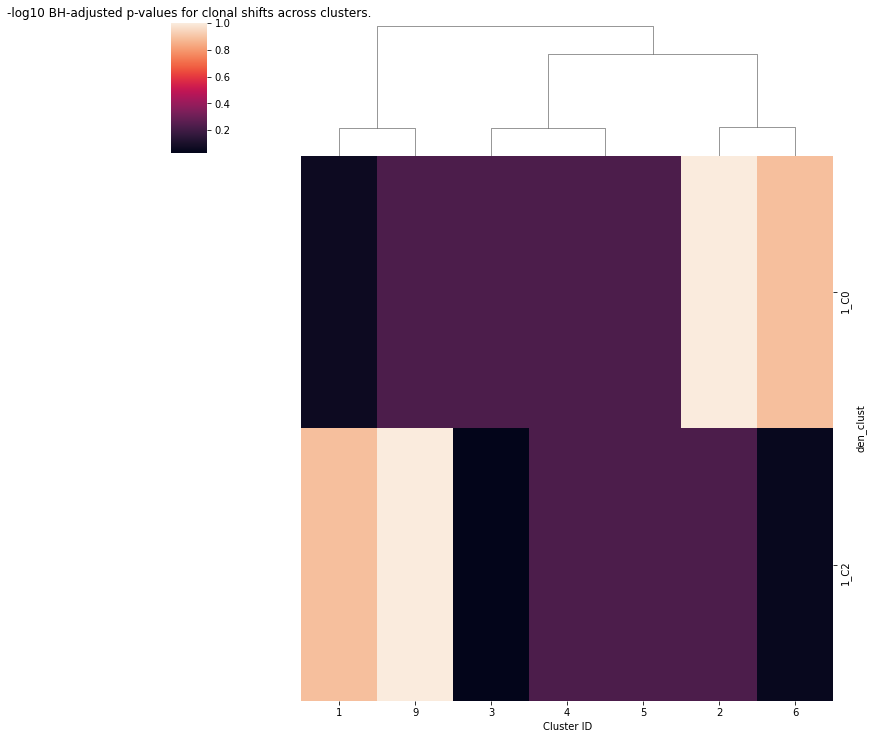

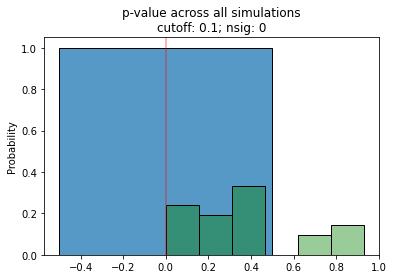

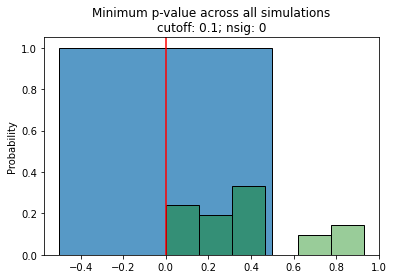

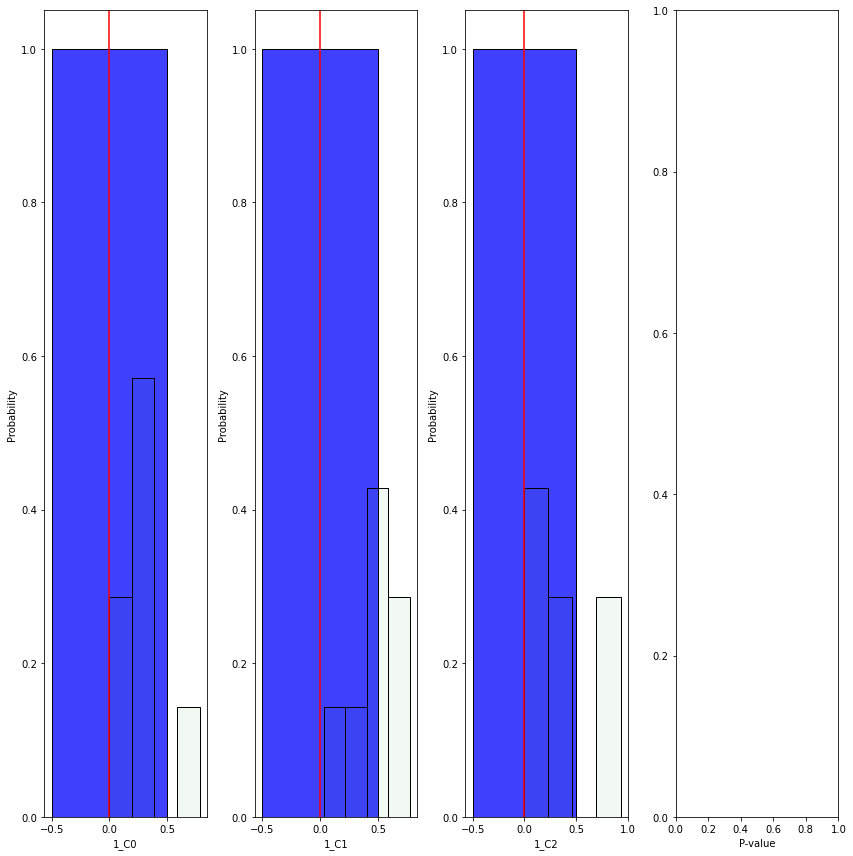

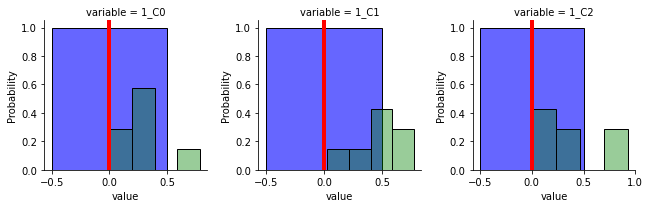

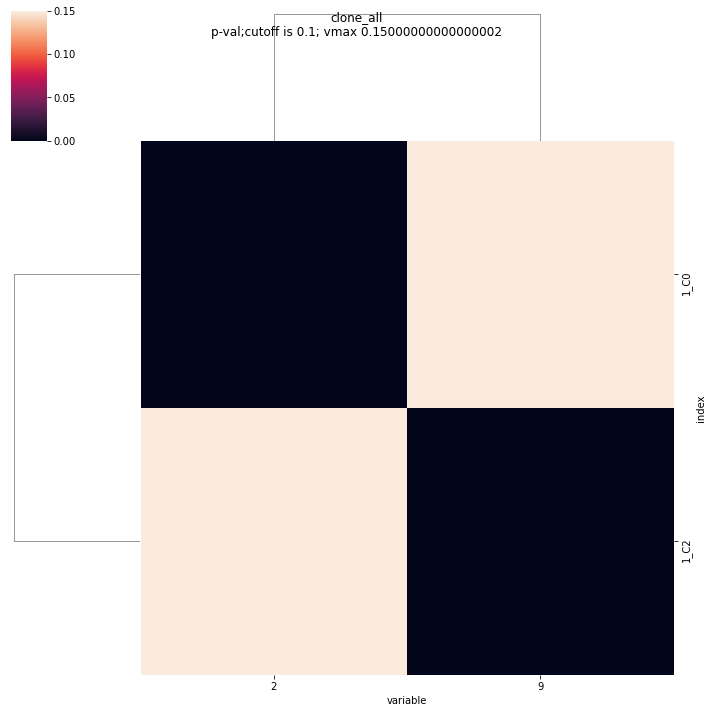

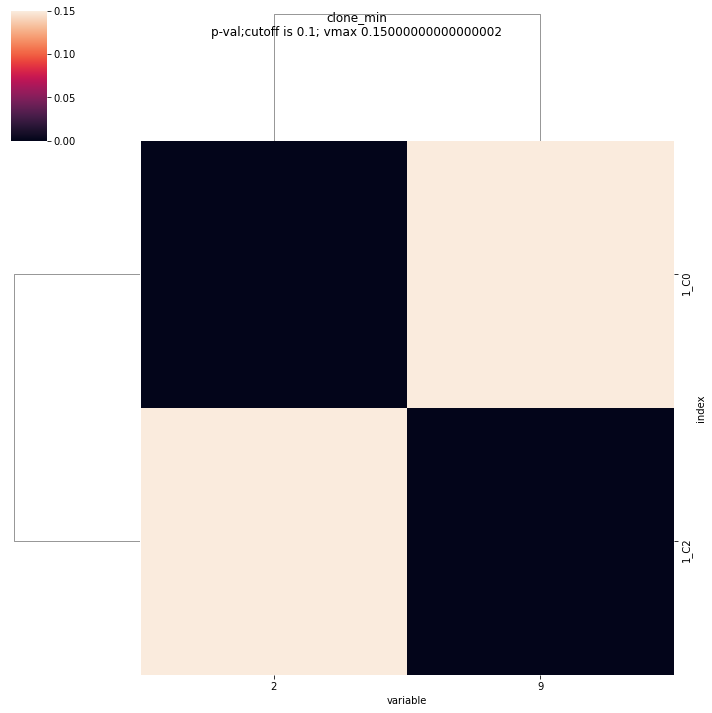

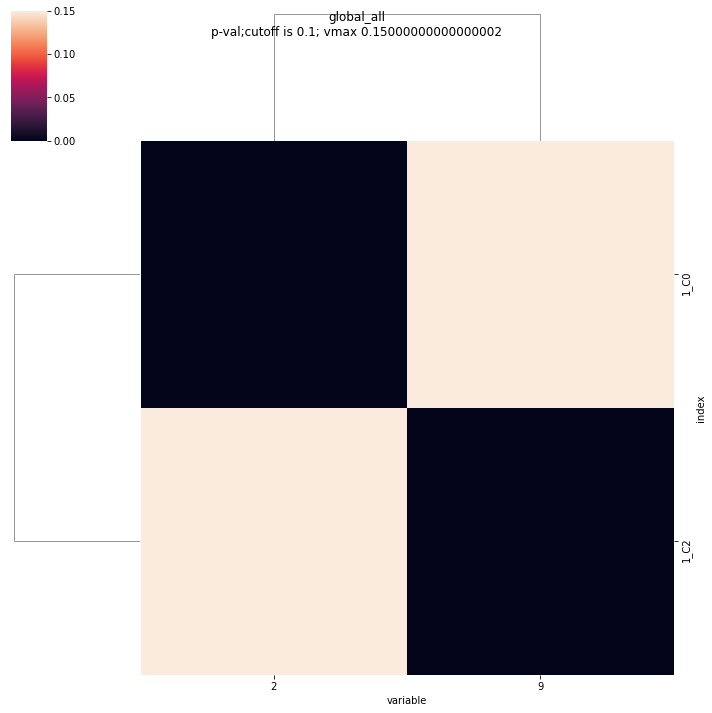

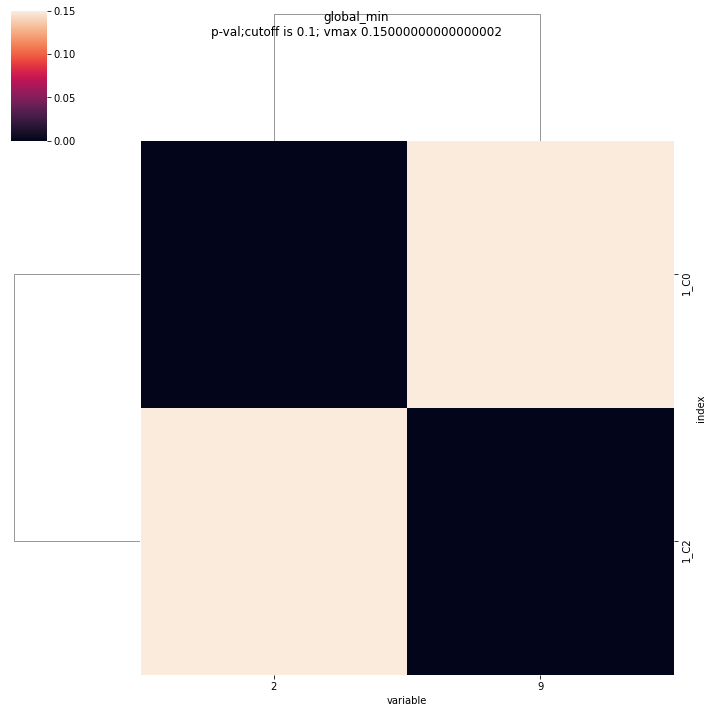

In [9]:
for d, val in cells_meta.groupby("donor"):
    print('donor', d)
    curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    curr_groups
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)
    
    curr_don_out = donor_out[int(d)]
    
    # Run init hypergeo and the counts data
    cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                      curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
#                                                              p_thresh=p_thresh, atac_col=atac_col, 
#                                                               clone_col=clone_col)
#     #cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes)

#     curr_don_out = donor_out[int(d)]
#     bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
    
#     init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
#                                               clones=curr_clones, atac_cl=curr_atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=24)

#     results_df, out_d = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
#                                                           curr_clone_map, atac_col, 
#                                                           outdir=join(curr_don_out, "shuffle"))
    
    
#     # plot just the counts
#     curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
#     g = sns.clustermap(curr_groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
#     plt.gca().set_title("log2 ncells")
#     plt.savefig(join(curr_don_out, "ncells.png"))
    

## B) Run using all donors as background

Running hypergeo and saving sig results
plotting counts
Running hypergeo shuffle and saving sig results


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 2
bh shape (6, 7)


ic| 'clone min'


out_df   index variable  value      method
9  1_C0        2    0.0  global_all
9  1_C0        2    0.0  global_min
9  1_C0        2    0.0   clone_all
9  1_C0        2    0.0   clone_min


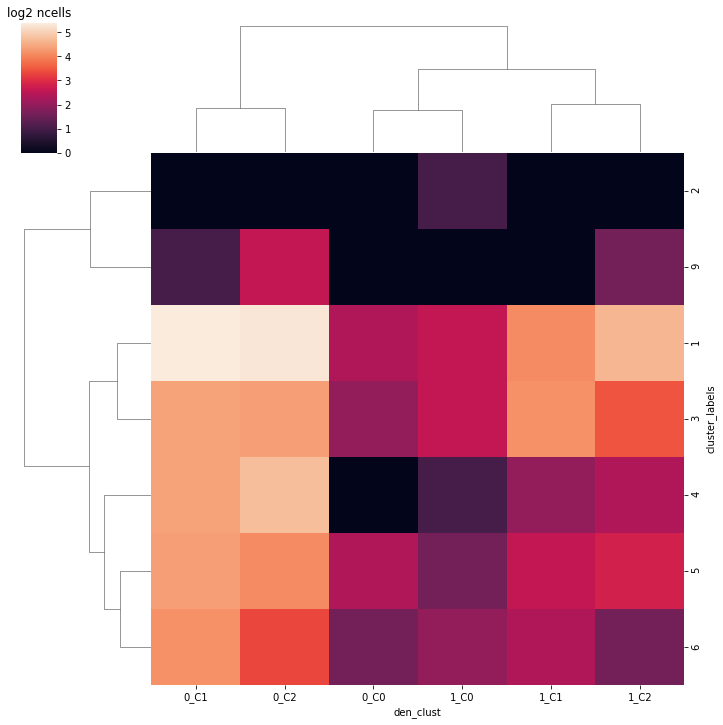

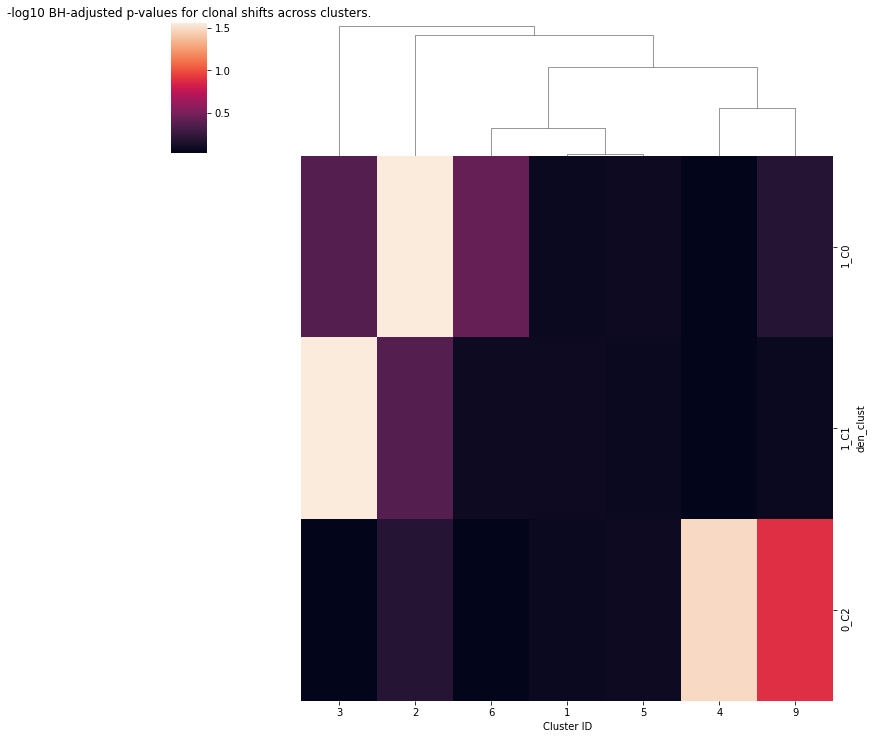

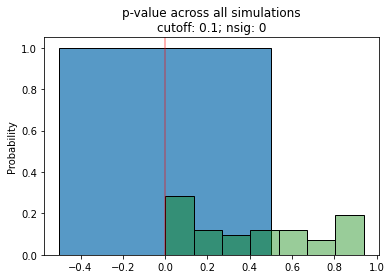

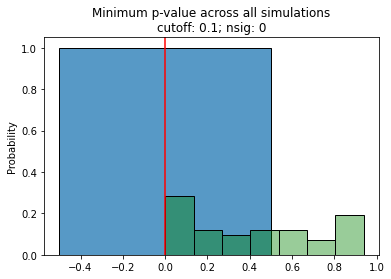

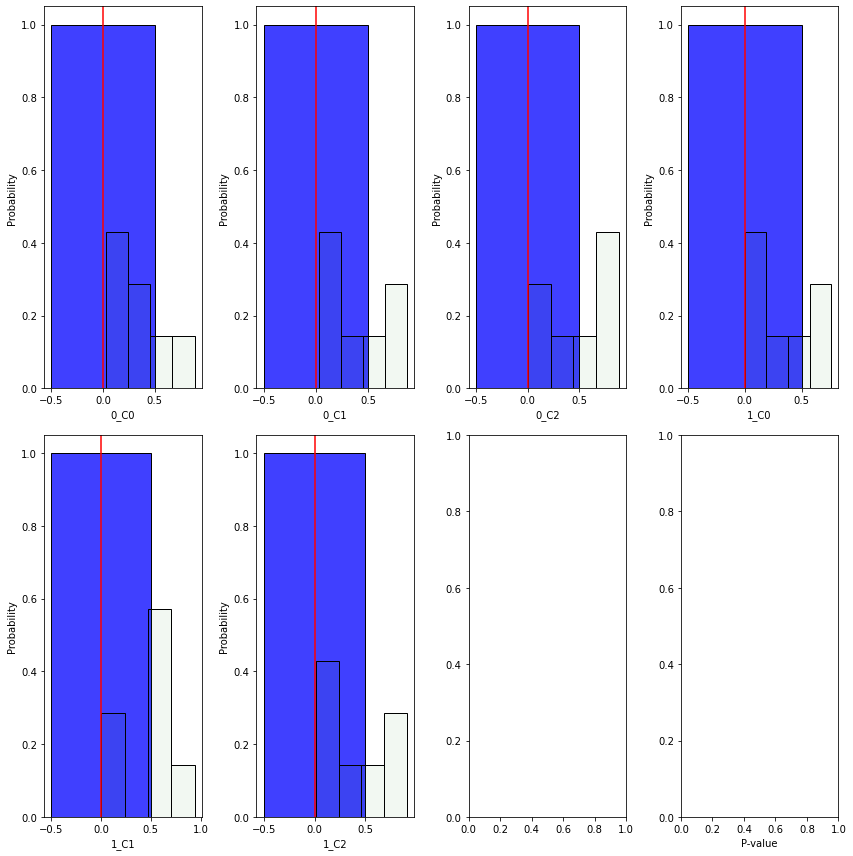

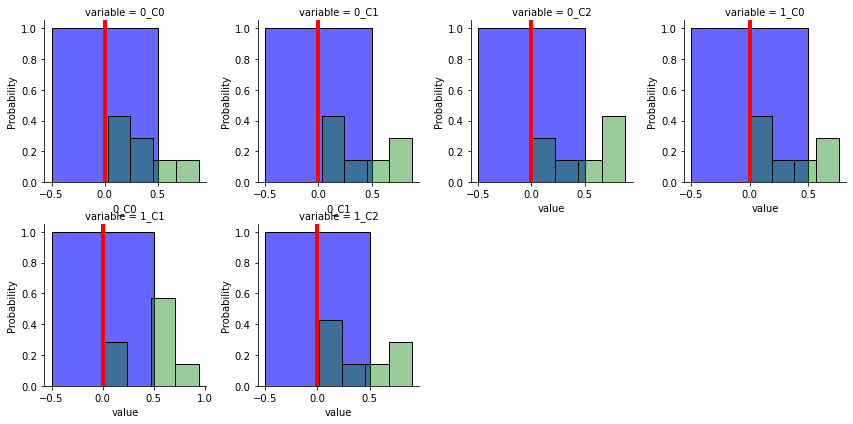

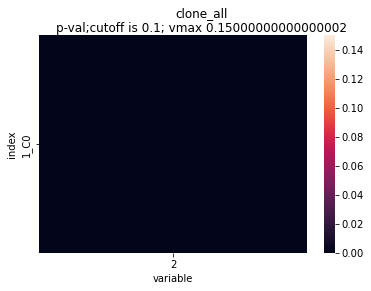

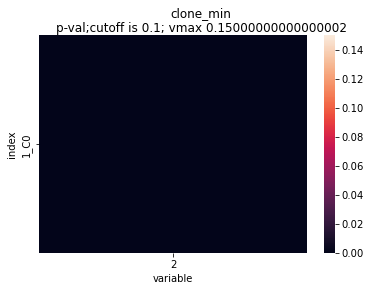

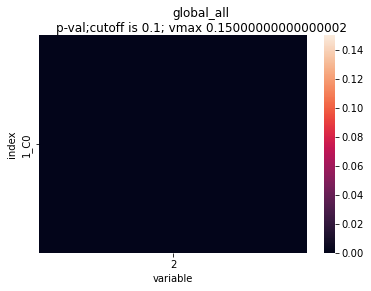

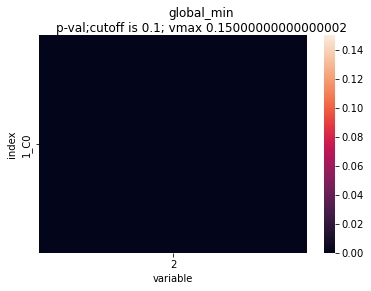

In [10]:
sizes = cells_meta.groupby(clone_col).size().sort_values(ascending=False)
name_cond_size = cells_meta.groupby([clone_col]).size()
name_cond_size = name_cond_size[name_cond_size>min_clone_size]
clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt.values #np.unique(groups["name"])
clone_map = {x:ind for ind,x in enumerate(clones)}

atac_cl = np.unique(groups[atac_col])
atac_cl


# Run init hypergeo
cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
               clone_col, all_dir)
## Run shuffle
print("Running hypergeo shuffle and saving sig results")
out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, all_dir, atac_col, clone_col, p_thresh, clones, 
                                                  atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                              n_cpus=n_cpus)

# output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,p_thresh, atac_col, clone_col)

# bh_enrichment_df.to_csv(join(all_dir, "hypergeo_input_padjusted.csv"))
# output_df.to_csv(join(all_dir, "hypergeo_input_padjusted_sigOnly.csv"))
    
# g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                row_cluster=False)

# g.ax_heatmap.set(xlabel="Cluster ID")
# g.ax_cbar.set(title="-log10 p-value")
# plt.savefig(join(all_dir, "hypergeo_input_padjusted_sigOnly.png"))



# ## Run shuffle
# init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
#                                           clones=clones, atac_cl=atac_cl)

# shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, n_shuffle=n_shuffle, 
#                               to_parallel=True, n_cpus=24)

# results_df, out_d = cs.get_out(shuffle, clones, bh_enrichment_df, p_thresh, clone_map, atac_col, 
#                                                      outdir=sim_all_dir)

In [11]:
out_df

,index,variable,value,method
9,1_C0,2,0.0,clone_all
9,1_C0,2,0.0,clone_min
9,1_C0,2,0.0,global_all
9,1_C0,2,0.0,global_min


In [12]:
# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=0.05)
#     plt.suptitle(ind)